In [29]:
import os
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

In [32]:
# Set random seed for reproducibility
np.random.seed(42)

# Dataset path
dataset_path = '/kaggle/input/ev2-dataset'

# Load data
def load_data():
    print("Loading dataset...")
    X = np.load(os.path.join(dataset_path, 'X.npy'))
    y = np.load(os.path.join(dataset_path, 'y.npy'))
    label_encoder = joblib.load(os.path.join(dataset_path, 'label_encoder.joblib'))
    scaler = joblib.load(os.path.join(dataset_path, 'scaler.joblib'))
    
    # Apply scaler
    X_scaled = scaler.transform(X)
    
    # Split data (88/12 to match paper's 1,433 train, 201 test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.12, random_state=42, stratify=y
    )
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, label_encoder


In [33]:
# Load data
X_train, y_train, X_test, y_test, label_encoder = load_data()

# Convert labels to indices
try:
    y_train_idx = label_encoder.transform(y_train)
    y_test_idx = label_encoder.transform(y_test)
    classes = ['P1', 'P2', 'P3']  # Explicitly set to P1, P2, P3
except:
    y_train_idx = y_train
    y_test_idx = y_test
    classes = ['P1', 'P2', 'P3']
    label_encoder.classes_ = classes

# Optimize SVM with GridSearchCV
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto']
}
base_svm = OneVsRestClassifier(SVC(probability=True, random_state=42))
grid_search = GridSearchCV(base_svm, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train_idx)

# Best model
model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Loading dataset...
X_train shape: (382, 10165), y_train shape: (382,)
X_test shape: (53, 10165), y_test shape: (53,)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Best parameters: {'estimator__C': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'linear'}
Best cross-validation F1 score: 0.6686


In [34]:
# Predict
y_pred_idx = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# Binarize labels for ROC and PR
y_test_bin = label_binarize(y_test_idx, classes=range(len(classes)))
n_classes = y_test_bin.shape[1]

# Confusion Matrix
cm = confusion_matrix(y_test_idx, y_pred_idx)

# Classification Report
report = classification_report(y_test_idx, y_pred_idx, target_names=classes, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_test_idx, y_pred_idx, target_names=classes))
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1 = [report[cls]['f1-score'] for cls in classes]
metrics_matrix = np.array([precision, recall, f1])


Classification Report:
              precision    recall  f1-score   support

          P1       0.74      0.81      0.78        32
          P2       0.40      0.25      0.31         8
          P3       0.46      0.46      0.46        13

    accuracy                           0.64        53
   macro avg       0.53      0.51      0.52        53
weighted avg       0.62      0.64      0.63        53



Text(120.72222222222221, 0.5, 'True')

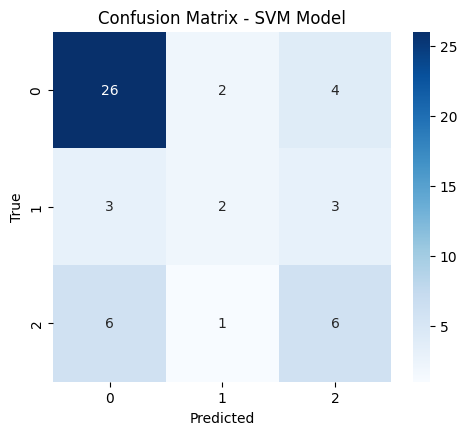

In [24]:
# ROC Curves
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Precision-Recall Curves
precision_pr = dict()
recall_pr = dict()
for i in range(n_classes):
    precision_pr[i], recall_pr[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])

# Plotting with enhanced aesthetics
plt.style.use('seaborn')  # Use seaborn style for better visuals
plt.figure(figsize=(16, 14), dpi=100)  # Larger figure size for clarity

Text(50.722222222222214, 0.5, 'True Label')

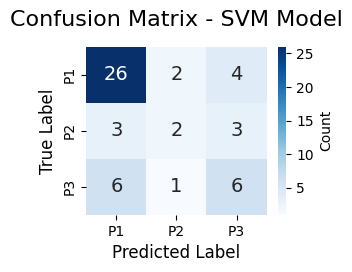

In [36]:
# Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes,
            annot_kws={"size": 14}, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - SVM Model', fontsize=16, pad=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)



Text(0.5, 1.0, 'Classification Metrics - SVM Model')

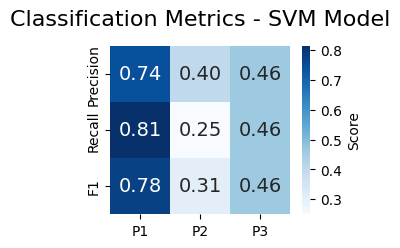

In [37]:
# Classification Metrics Heatmap
plt.subplot(2, 2, 2)
sns.heatmap(metrics_matrix, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=classes, yticklabels=['Precision', 'Recall', 'F1'],
            annot_kws={"size": 14}, cbar_kws={'label': 'Score'})
plt.title('Classification Metrics - SVM Model', fontsize=16, pad=15)

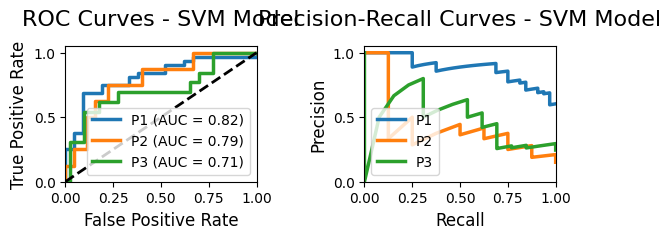

In [38]:
# ROC Curves
plt.subplot(2, 2, 3)
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c'])  # Custom colors for P1, P2, P3
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2.5, 
             label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - SVM Model', fontsize=16, pad=15)
plt.legend(loc="lower right", fontsize=10)

# Precision-Recall Curves
plt.subplot(2, 2, 4)
for i, color in zip(range(n_classes), colors):
    plt.plot(recall_pr[i], precision_pr[i], color=color, lw=2.5, 
             label=f'{classes[i]}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - SVM Model', fontsize=16, pad=15)
plt.legend(loc="lower left", fontsize=10)

plt.tight_layout(pad=3.0)
plt.savefig('/kaggle/working/svm_results.png', bbox_inches='tight', dpi=150)
plt.show()


In [40]:
# Save final model
joblib.dump(model, '/kaggle/working/svm_vehicle_classifier_optimized.pkl')
print("Model saved as '/kaggle/working/svm_vehicle_classifier_optimized.pkl'")

Model saved as '/kaggle/working/svm_vehicle_classifier_optimized.pkl'
